In [1]:
import gym
import torch
import lbforaging
import decision_transformer.models.decision_transformer
import numpy as np
from itertools import product

import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import rware

In [52]:
env_name = "hopper-medium-v2"

dataset_path = f'data/{env_name}.pkl'
with open(dataset_path, 'rb') as f:
    trajectories_hopper = pickle.load(f)
    
states, traj_lens, returns = [], [], []
for path in trajectories2:
    states.append(path['states'])

# used for input normalization
states = np.concatenate(states, axis=0)
state_mean_global, state_std_global = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

In [39]:
path_to_model = "/work3/s174437/Blankuca/decision-transformer/dataset/saved_models/model_cooperative.pt"

In [40]:
behavior = "cooperative"
env = gym.make("Foraging-8x8-2p-3f-v2")
state_dim = env.observation_space[0].shape[0] * 2
act_dim = 1
device='cpu'
model = torch.load(path_to_model, map_location=torch.device('cpu'))
max_ep_len=10000
scale=1
target_return=torch.Tensor([0.5,0.5], device=device)
mode='normal'
state_mean=state_mean_global
state_std=state_std_global

/zhome/09/9/127654/anaconda3/envs/decision-transformer-gym/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [41]:
model.eval()
model.to(device=device)

num_agents = env.n_agents

state_mean = torch.from_numpy(state_mean).to(device=device)
state_std = torch.from_numpy(state_std).to(device=device)

env_global = env.reset()
states = env_global
state = np.concatenate(states)
if mode == 'noise':
    state = state + np.random.normal(0, 0.1, size=state.shape)

# we keep all the histories on the device
# note that the latest action and reward will be "padding"
states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
rewards = torch.zeros(num_agents, 0, device=device, dtype=torch.float32)

ep_return = target_return
target_return = torch.tensor(ep_return, device=device, dtype=torch.float32).reshape(num_agents,1, 1)
timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)

sim_states = []

avail_actions = list(range(len(env.action_set) + 1))
combinations = list(product(avail_actions, repeat=num_agents))
enc_action_to_actions = {i:comb for i,comb in enumerate(combinations)}
actions_to_enc_actions = {comb:i for i,comb in enumerate(combinations)}

episode_return, episode_length = torch.zeros(num_agents, device=device, dtype=torch.float32), 0

record_actions = []
for t in range(max_ep_len):

    # add padding
    actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
    rewards = torch.cat([rewards, torch.zeros(num_agents,1, device=device)], dim=1)


    action = model.get_action(
        (states.to(dtype=torch.float32) - state_mean) / state_std,
        actions.to(dtype=torch.float32),
        rewards.to(dtype=torch.float32),
        target_return.to(dtype=torch.float32),
        timesteps.to(dtype=torch.long),
    )
    action = action.argmax(dim=1).tolist()
    record_actions.append(action)
    actions[-1] = actions_to_enc_actions[tuple(action)]

    state, reward, done, _ = env.step(action)
    state = np.concatenate(state)

    reward = torch.FloatTensor(reward).to(device=device)
    episode_return = episode_return.add(reward)
    episode_length += 1
    
    done = all(done)

    cur_state = torch.from_numpy(state).to(device=device).reshape(1, state_dim)
    states = torch.cat([states, cur_state], dim=0)
    rewards[:,-1] = reward

    if mode != 'delayed':
        pred_return = target_return[:,0,-1].sub(reward/scale)
    else:
        pred_return = target_return[:,0,-1]
    target_return = torch.cat(
        [target_return, pred_return.reshape(-1, 1, 1)], dim=1)
    timesteps = torch.cat(
        [timesteps,
            torch.ones((1, 1), device=device, dtype=torch.long) * (t+1)], dim=1)

    if done:
        break

/tmp/ipykernel_19177/3566384189.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_return = torch.tensor(ep_return, device=device, dtype=torch.float32).reshape(num_agents,1, 1)


In [9]:
def show_state(env, step=0, info=""):
    plt.figure(3, figsize=(10,10))
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    #plt.title("%s | Step: %d %s" % ("env",step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    #display.display(plt.gcf())

In [7]:

#prev_screen = env.render(mode='rgb_array')
#plt.imshow(prev_screen)
env = env_global

i = 0
for action in record_actions:
  i += 1
  obs, reward, done, info = env.step(action)
  show_state(env, step=i)
  #screen = env.render(mode='rgb_array')
  
  #plt.imshow(screen)
  #ipythondisplay.clear_output(wait=True)
  #ipythondisplay.display(plt.gcf())

  if done:
    break

NameError: name 'record_actions' is not defined

In [1]:
import gym
import torch
import lbforaging
import decision_transformer.models.decision_transformer
import numpy as np
from itertools import product

import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import rware

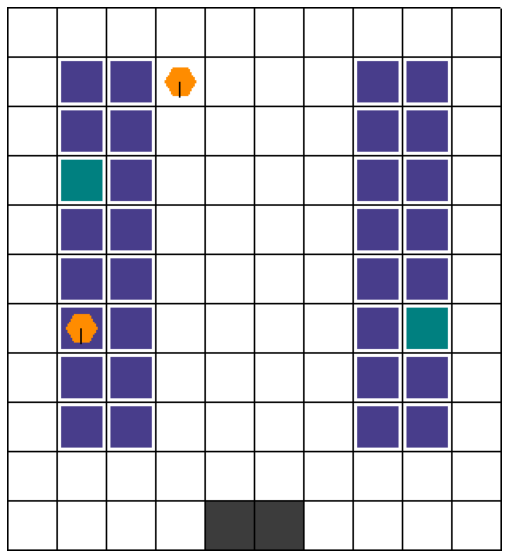

In [11]:
env = gym.make("rware-tiny-2ag-v1", request_queue_size=2)
env.reset()
show_state(env)

0 = nothing
1 = move foward
2 = rotate counter-clockwise
3 = rotate clock-wise
4 = load

[1.0, 2.0]


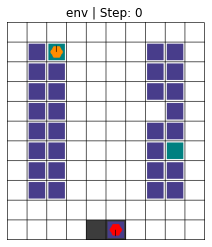

In [98]:
obs, r, _, _ = env.step([1,1])
show_state(env)
rewards = [r[0]+rewards[0], r[1]+rewards[1]]
print(rewards)

In [49]:
rewards

[0.0, 1.0]

In [117]:
env.request_queue[0].x, env.request_queue[0].y

(2, 7)

In [118]:
env.request_queue[1].x, env.request_queue[1].y

(2, 6)

In [99]:
env.step([0,0])

((array([ 5., 10.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
          0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.], dtype=float32),
  array([0., 8., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
         0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0.], dtype=float32)),
 [0.0, 0.0],
 [False, False],
 {})

In [122]:
obs[0]

array([7., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0.], dtype=float32)

In [123]:
obs[1]

array([4., 9., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0.], dtype=float32)

In [124]:
env.request_queue

In [125]:
[(q.x,q.y) for q in env.request_queue]

[(2, 7), (2, 6)]

In [10]:
trajectories[3]["rewards"].sum(axis=0)

array([0.        , 0.        , 0.        , 0.33333333, 0.        ,
       0.        , 0.33333333, 0.        , 0.        , 0.        ,
       0.        , 0.33333333])

In [15]:
len(trajectories[2]["rewards"].sum(axis=0))

50

In [44]:
trajectories2[6]["states"][0] == trajectories2[6]["states"][1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True])

In [45]:
trajectories2[6]["states"]

array([[ 1.,  1.,  1.,  1.,  6.,  1.,  5.,  6.,  1.,  3.,  6.,  1.,  1.,
         3.,  1.,  1.,  1.,  1.,  1.,  6.,  1.,  5.,  6.,  1.,  1.,  3.,
         1.,  3.,  6.,  1.],
       [ 1.,  1.,  1.,  1.,  6.,  1.,  5.,  6.,  1.,  3.,  5.,  1.,  1.,
         2.,  1.,  1.,  1.,  1.,  1.,  6.,  1.,  5.,  6.,  1.,  1.,  2.,
         1.,  3.,  5.,  1.],
       [ 1.,  6.,  1.,  5.,  6.,  1., -1., -1.,  0.,  3.,  4.,  1.,  1.,
         2.,  1.,  1.,  6.,  1.,  5.,  6.,  1., -1., -1.,  0.,  1.,  2.,
         1.,  3.,  4.,  1.],
       [ 1.,  6.,  1.,  5.,  6.,  1., -1., -1.,  0.,  3.,  4.,  1.,  1.,
         3.,  1.,  1.,  6.,  1.,  5.,  6.,  1., -1., -1.,  0.,  1.,  3.,
         1.,  3.,  4.,  1.],
       [ 1.,  6.,  1.,  5.,  6.,  1., -1., -1.,  0.,  3.,  5.,  1.,  1.,
         4.,  1.,  1.,  6.,  1.,  5.,  6.,  1., -1., -1.,  0.,  1.,  4.,
         1.,  3.,  5.,  1.],
       [ 1.,  6.,  1.,  5.,  6.,  1., -1., -1.,  0.,  3.,  6.,  1.,  1.,
         5.,  1.,  1.,  6.,  1.,  5.,  6.,  1., -1.,

In [38]:
len(trajectories2[6]["actions"][0])

11

In [30]:
len(trajectories[4]["rewards"][0])

22

In [31]:
trajectories[4]["actions"]

array([[3, 3, 2, 5, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 5, 3, 3, 5],
       [3, 3, 5, 5, 2, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 2]])

In [46]:
sum([t["rewards"].sum(axis=0)[-1] for t in trajectories2])

2092.024999999978

In [49]:
trajectories2[6]["rewards"].sum(axis=0)[-1]

0.3333333333333333

In [51]:
trajectories2[6]["rewards"].sum(axis=0)

array([0.        , 0.        , 0.33333333, 0.        , 0.        ,
       0.        , 0.        , 0.33333333, 0.        , 0.        ,
       0.33333333])

In [63]:
trajectories_hopper[0]["observations"][1] == trajectories_hopper[0]["next_observations"][0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [59]:
trajectories_hopper[0].keys()

dict_keys(['observations', 'next_observations', 'actions', 'rewards', 'terminals'])